# FunkSVD Matrix Factorization

Implementation of FunkSVD (SGD-based matrix factorization) for collaborative filtering on MovieLens dataset.

## 1. Imports and Data Loading

The split is temporal 75/12.5/12.5, so the model is trained on past interactions and evaluated on future ones.

In [2]:
!git clone https://$GITHUB_TOKEN@github.com/Its-OP/ucu-rs-2026.git

Cloning into 'ucu-rs-2026'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 241 (delta 35), reused 48 (delta 23), pack-reused 168 (from 1)
Receiving objects: 100% (241/241), 78.76 MiB | 40.49 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [3]:
%cd ucu-rs-2026

/content/ucu-rs-2026


We fix random seeds so initialization and shuffling behave consistently across runs, and we reduce noisy warnings/logs to keep the training output readable.

In [4]:
from __future__ import annotations

import os
import sys
import random
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt

sys.path.append(str(Path(".").resolve()))

from src.models.base import RecommenderModel, Rating
from src.eval.eval import evaluate
from data.dataframes import movies_enriched, users, train, test

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("src.eval.eval").setLevel(logging.ERROR)

In [5]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

## 2. FunkSVD Model Implementation

This is a matrix factorization trained with SGD (not closed-form as in ALS). It usually performs well because it learns bias terms and can fit explicit ratings directly.

Prediction formula:

$$
\hat{r}_{ui} = \mu + b_u + b_i + p_u^\top q_i
$$

Here:

* $\mu$ global mean
* $b_u$ user bias, $b_i$ item bias
* $p_u, q_i$ user/item factors

We minimize squared error with L2 regularization:

$$
\min \sum_{(u,i)\in\Omega} (r_{ui}-\hat{r}_{ui})^2 + \lambda(\lVert p_u\rVert^2+\lVert q_i\rVert^2+b_u^2+b_i^2)
$$

For each observed $u, i, r$, compute error $e_{ui}=r_{ui}-\hat{r}_{ui}$, then update biases and factors and store RMSE loss.

At inference we score all items for a user with one vectorized expression:

$$
\hat{r}*{u*} = \mu + b_u + b** + Qp_u
$$

That’s why `scores = ... + self.item_factors @ self.user_factors[u_idx]` is efficient.

In [6]:
class FunkSVDRecommender(RecommenderModel):
    """FunkSVD matrix factorization using stochastic gradient descent.

    Parameters
    ----------
    n_factors : int
        Dimensionality of latent factors.
    n_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for SGD.
    regularization : float
        L2 regularization strength.
    random_state : int
        Seed for reproducibility.
    """

    def __init__(
        self,
        n_factors: int = 50,
        n_epochs: int = 20,
        lr: float = 0.005,
        regularization: float = 0.02,
        random_state: int = 42,
    ):
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.regularization = regularization
        self.random_state = random_state

        self.global_mean: float = 0.0
        self.user_bias: np.ndarray | None = None
        self.item_bias: np.ndarray | None = None
        self.user_factors: np.ndarray | None = None
        self.item_factors: np.ndarray | None = None

        self.user_to_idx: Dict[int, int] = {}
        self.item_to_idx: Dict[int, int] = {}
        self.idx_to_item: Dict[int, int] = {}

        self.loss_history_: List[float] = []

    def fit(self, ratings: pd.DataFrame) -> "FunkSVDRecommender":
        np.random.seed(self.random_state)

        # mappings
        users_list = ratings["UserID"].unique()
        items_list = ratings["MovieID"].unique()

        self.user_to_idx = {u: i for i, u in enumerate(users_list)}
        self.item_to_idx = {m: i for i, m in enumerate(items_list)}
        self.idx_to_item = {i: m for m, i in self.item_to_idx.items()}

        n_users = len(users_list)
        n_items = len(items_list)

        # params
        self.global_mean = ratings["Rating"].mean()
        self.user_bias = np.zeros(n_users, dtype=np.float32)
        self.item_bias = np.zeros(n_items, dtype=np.float32)
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors)).astype(np.float32)
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors)).astype(np.float32)

        train_data = ratings[["UserID", "MovieID", "Rating"]].values

        # train
        for epoch in range(self.n_epochs):
            np.random.shuffle(train_data)
            total_loss = 0.0

            for uid, mid, rating in train_data:
                u_idx = self.user_to_idx[uid]
                i_idx = self.item_to_idx[mid]

                # predict
                pred = (
                    self.global_mean
                    + self.user_bias[u_idx]
                    + self.item_bias[i_idx]
                    + self.user_factors[u_idx] @ self.item_factors[i_idx]
                )

                # loss
                err = rating - pred
                total_loss += err ** 2

                # biases/factors update
                self.user_bias[u_idx] += self.lr * (err - self.regularization * self.user_bias[u_idx])
                self.item_bias[i_idx] += self.lr * (err - self.regularization * self.item_bias[i_idx])

                u_factors_old = self.user_factors[u_idx].copy()
                self.user_factors[u_idx] += self.lr * (err * self.item_factors[i_idx] - self.regularization * self.user_factors[u_idx])
                self.item_factors[i_idx] += self.lr * (err * u_factors_old - self.regularization * self.item_factors[i_idx])

            rmse = np.sqrt(total_loss / len(train_data))
            self.loss_history_.append(rmse)
            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch + 1}/{self.n_epochs}, RMSE: {rmse:.4f}")

        return self

    def _predict_score(self, u_idx: int, i_idx: int) -> float:
        return (
            self.global_mean
            + self.user_bias[u_idx]
            + self.item_bias[i_idx]
            + self.user_factors[u_idx] @ self.item_factors[i_idx]
        )

    def predict(
        self,
        users: pd.DataFrame,
        ratings: pd.DataFrame,
        movies: pd.DataFrame,
        k: int = 10,
    ) -> Dict[int, List[Rating]]:
        ratings_by_user = {uid: set(grp["MovieID"].values) for uid, grp in ratings.groupby("UserID")}

        preds: Dict[int, List[Rating]] = {}
        n_items = len(self.item_to_idx)

        for uid in users["UserID"].values:
            uid = int(uid)
            seen = ratings_by_user.get(uid, set())

            if uid not in self.user_to_idx:
                preds[uid] = []
                continue

            u_idx = self.user_to_idx[uid]

            # scores for all items
            scores = (
                self.global_mean
                + self.user_bias[u_idx]
                + self.item_bias
                + self.item_factors @ self.user_factors[u_idx]
            )

            # mask seen items
            for mid in seen:
                if mid in self.item_to_idx:
                    scores[self.item_to_idx[mid]] = -np.inf

            # top-k
            top_indices = np.argpartition(-scores, min(k, n_items - 1))[:k]
            top_indices = top_indices[np.argsort(-scores[top_indices])]

            preds[uid] = [
                Rating(movie_id=int(self.idx_to_item[i]), score=float(scores[i]))
                for i in top_indices
                if scores[i] > -np.inf
            ]

        return preds

## 3. Hyperparameter Configurations

We test FunkSVD with different configurations to understand the impact of:
- Number of latent factors
- Learning rate
- Regularization strength

In [7]:
FUNKSVD_CONFIGS = [
  # factor sweep
  {"name":"funk_f50_lr0.01_r0.02",   "n_factors":50,  "lr":0.01, "regularization":0.02},
  {"name":"funk_f100_lr0.01_r0.02",  "n_factors":100, "lr":0.01, "regularization":0.02},
  {"name":"funk_f150_lr0.01_r0.02",  "n_factors":150, "lr":0.01, "regularization":0.02},

  # lr sweep
  {"name":"funk_f100_lr0.005_r0.02", "n_factors":100, "lr":0.005, "regularization":0.02},
  {"name":"funk_f100_lr0.02_r0.02",  "n_factors":100, "lr":0.02,  "regularization":0.02},
  {"name":"funk_f100_lr0.05_r0.02",  "n_factors":100, "lr":0.05,  "regularization":0.02},

  # reg sweep
  {"name":"funk_f100_lr0.01_r0.005", "n_factors":100, "lr":0.01, "regularization":0.005},
  {"name":"funk_f100_lr0.01_r0.01",  "n_factors":100, "lr":0.01, "regularization":0.01},
  {"name":"funk_f100_lr0.01_r0.05",  "n_factors":100, "lr":0.01, "regularization":0.05},

  # couple of combos that we expect to win
  {"name":"funk_f150_lr0.005_r0.02", "n_factors":150, "lr":0.005, "regularization":0.02},
  {"name":"funk_f150_lr0.01_r0.01",  "n_factors":150, "lr":0.01,  "regularization":0.01},
]


K_VALUES = [10]
THRESHOLD = 4.0

## 4. Training and Evaluation

In [8]:
results = []
models = {}

for config in FUNKSVD_CONFIGS:
    name = config["name"]
    print(f"\nTraining: {name}")
    print(f"{'-'*30}")

    model = FunkSVDRecommender(
        n_factors=config["n_factors"],
        n_epochs=15,
        lr=config["lr"],
        regularization=config["regularization"],
    )
    model.fit(train)
    models[name] = model

    for k in K_VALUES:
        metrics = evaluate(
            model=model,
            train_ratings=train,
            test_ratings=test,
            users=users,
            movies=movies_enriched,
            k=k,
            threshold=THRESHOLD,
        )

        results.append({
            "model": name,
            "k": k,
            "ndcg": metrics.ndcg,
            "precision": metrics.precision,
            "recall": metrics.recall,
        })


Training: funk_f50_lr0.01_r0.02
------------------------------
  Epoch 5/15, RMSE: 0.8690
  Epoch 10/15, RMSE: 0.7698
  Epoch 15/15, RMSE: 0.6973

Training: funk_f100_lr0.01_r0.02
------------------------------
  Epoch 5/15, RMSE: 0.8387
  Epoch 10/15, RMSE: 0.7063
  Epoch 15/15, RMSE: 0.6088

Training: funk_f150_lr0.01_r0.02
------------------------------
  Epoch 5/15, RMSE: 0.8136
  Epoch 10/15, RMSE: 0.6578
  Epoch 15/15, RMSE: 0.5478

Training: funk_f100_lr0.005_r0.02
------------------------------
  Epoch 5/15, RMSE: 0.8833
  Epoch 10/15, RMSE: 0.8223
  Epoch 15/15, RMSE: 0.7508

Training: funk_f100_lr0.02_r0.02
------------------------------
  Epoch 5/15, RMSE: 0.7462
  Epoch 10/15, RMSE: 0.5822
  Epoch 15/15, RMSE: 0.5154

Training: funk_f100_lr0.05_r0.02
------------------------------
  Epoch 5/15, RMSE: 0.6414
  Epoch 10/15, RMSE: 0.5501
  Epoch 15/15, RMSE: 0.5242

Training: funk_f100_lr0.01_r0.005
------------------------------
  Epoch 5/15, RMSE: 0.8117
  Epoch 10/15, RMSE

## 5. Convergence Analysis

FunkSVD uses SGD which updates parameters after each sample.
We track RMSE per epoch to observe convergence behavior.

Observations:
- Higher learning rate → faster initial descent but may oscillate
- Higher regularization → higher final RMSE but better generalization
- More factors → lower training RMSE but risk of overfitting

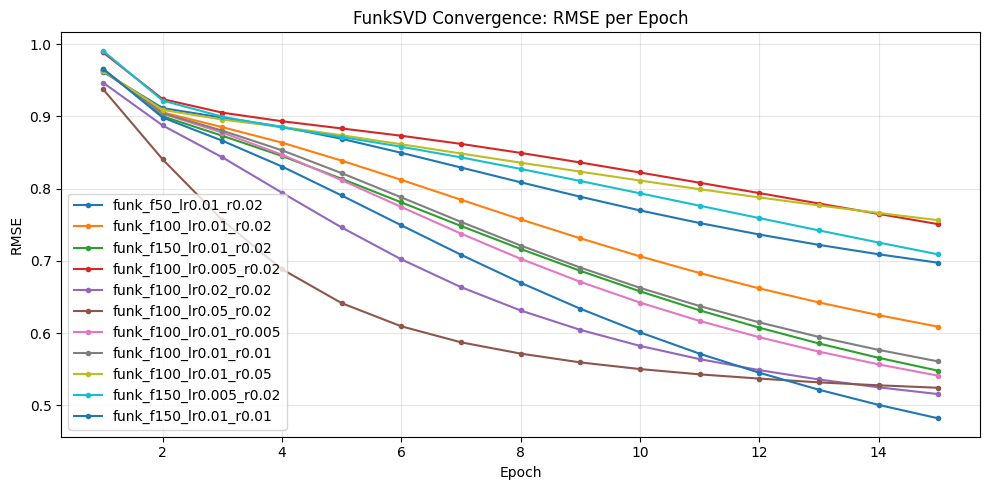

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

for name, model in models.items():
    ax.plot(range(1, len(model.loss_history_) + 1), model.loss_history_, label=name, marker='o', markersize=3)

ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")
ax.set_title("FunkSVD Convergence: RMSE per Epoch")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Results Summary

In [10]:
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.to_string(index=False))

print("\n\nNDCG@K by Model:")
ndcg_pivot = results_df.pivot(index="model", columns="k", values="ndcg")
print(ndcg_pivot.round(4))

print("\n\nPrecision@K by Model:")
prec_pivot = results_df.pivot(index="model", columns="k", values="precision")
print(prec_pivot.round(4))

print("\n\nRecall@K by Model:")
recall_pivot = results_df.pivot(index="model", columns="k", values="recall")
print(recall_pivot.round(4))


All Results:
                  model  k     ndcg  precision   recall
  funk_f50_lr0.01_r0.02 10 0.091191   0.083375 0.020949
 funk_f100_lr0.01_r0.02 10 0.082505   0.076324 0.019277
 funk_f150_lr0.01_r0.02 10 0.084076   0.074608 0.017536
funk_f100_lr0.005_r0.02 10 0.079348   0.073428 0.018739
 funk_f100_lr0.02_r0.02 10 0.068687   0.061235 0.014503
 funk_f100_lr0.05_r0.02 10 0.054382   0.051647 0.011680
funk_f100_lr0.01_r0.005 10 0.085251   0.074747 0.017569
 funk_f100_lr0.01_r0.01 10 0.083208   0.074054 0.017622
 funk_f100_lr0.01_r0.05 10 0.077837   0.073592 0.018398
funk_f150_lr0.005_r0.02 10 0.083726   0.074164 0.018078
 funk_f150_lr0.01_r0.01 10 0.082300   0.073141 0.016974


NDCG@K by Model:
k                            10
model                          
funk_f100_lr0.005_r0.02  0.0793
funk_f100_lr0.01_r0.005  0.0853
funk_f100_lr0.01_r0.01   0.0832
funk_f100_lr0.01_r0.02   0.0825
funk_f100_lr0.01_r0.05   0.0778
funk_f100_lr0.02_r0.02   0.0687
funk_f100_lr0.05_r0.02   0.0544
funk_f1

## 7. Best Model Selection

In [11]:
# at K=10
k10_results = results_df[results_df["k"] == 10].sort_values("ndcg", ascending=False)
print("\nModels ranked by NDCG@10:")
print(k10_results.to_string(index=False))

best_model_name = k10_results.iloc[0]["model"]
print(f"\nBest model: {best_model_name}")


Models ranked by NDCG@10:
                  model  k     ndcg  precision   recall
  funk_f50_lr0.01_r0.02 10 0.091191   0.083375 0.020949
funk_f100_lr0.01_r0.005 10 0.085251   0.074747 0.017569
 funk_f150_lr0.01_r0.02 10 0.084076   0.074608 0.017536
funk_f150_lr0.005_r0.02 10 0.083726   0.074164 0.018078
 funk_f100_lr0.01_r0.01 10 0.083208   0.074054 0.017622
 funk_f100_lr0.01_r0.02 10 0.082505   0.076324 0.019277
 funk_f150_lr0.01_r0.01 10 0.082300   0.073141 0.016974
funk_f100_lr0.005_r0.02 10 0.079348   0.073428 0.018739
 funk_f100_lr0.01_r0.05 10 0.077837   0.073592 0.018398
 funk_f100_lr0.02_r0.02 10 0.068687   0.061235 0.014503
 funk_f100_lr0.05_r0.02 10 0.054382   0.051647 0.011680

Best model: funk_f50_lr0.01_r0.02


## 8. Example Recommendations

In [12]:
example_user = int(train["UserID"].value_counts().index[0])
print(f"\nExample recommendations for user {example_user}:")

best_model = models[best_model_name]
recs = best_model.predict(
    users=users[users["UserID"] == example_user],
    ratings=train,
    movies=movies_enriched,
    k=10
)[example_user]

rec_ids = [r.movie_id for r in recs]
rec_scores = {r.movie_id: r.score for r in recs}

show_df = movies_enriched[movies_enriched["movie_id"].isin(rec_ids)][["movie_id", "title", "year", "genres"]].copy()
show_df["rank"] = show_df["movie_id"].map({mid: i+1 for i, mid in enumerate(rec_ids)})
show_df["score"] = show_df["movie_id"].map(rec_scores).round(3)
show_df = show_df.sort_values("rank")

print(show_df.to_string(index=False))


Example recommendations for user 1680:
 movie_id                                                title  year                                          genres  rank  score
     3328                    Ghost Dog: The Way of the Samurai  1999                                     Crime|Drama     1  5.450
     3182 Mr. Death: The Rise and Fall of Fred A. Leuchter Jr.  1999                                     Documentary     2  5.258
     2905                                              Sanjuro  1962                                Action|Adventure     3  5.211
     3808                              Two Women (La Ciociara)  1961                                       Drama|War     4  5.159
     1296                                  Room with a View, A  1986                                   Drama|Romance     5  5.157
     2859                                    Stop Making Sense  1984                                     Documentary     6  5.104
      307                                   Three 

## 9. User History for Context

In [13]:
user_history = train[train["UserID"] == example_user].merge(
    movies_enriched[["movie_id", "title", "genres"]],
    left_on="MovieID",
    right_on="movie_id"
).sort_values("Rating", ascending=False)

print(f"\nUser {example_user}'s top-rated movies in training set:")
print(user_history[["title", "genres", "Rating"]].head(10).to_string(index=False))


User 1680's top-rated movies in training set:
                title                     genres  Rating
            Manhattan       Comedy|Drama|Romance       5
      Sophie's Choice                      Drama       5
     Mulholland Falls   Crime|Film-Noir|Thriller       5
     Crying Game, The          Drama|Romance|War       5
       Basic Instinct           Mystery|Thriller       5
            Chinatown Film-Noir|Mystery|Thriller       5
Bringing Out the Dead               Drama|Horror       5
                Trust               Comedy|Drama       5
     Harold and Maude                     Comedy       5
           Sting, The               Comedy|Crime       5
